# Landmark Classifier

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo’s location can often be obtained by looking at the photo’s metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo’s metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

This notebook classifies 50 landmarks by building models to automatically predict the location of the image based on any landmarks depicted in the image.

### Table of Content

In [1]:
# import all the packages
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchsummary import summary

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

from utils import models, preprocess

In [2]:
# define the batch size
BATCH_SIZE = 64

# get the loaders
train_loader, val_loader, test_loader, dataset = preprocess.create_loaders(n_batch=BATCH_SIZE)

In [3]:
# store loaders
loaders = {'train': train_loader,
           'val':   val_loader,
           'test':  test_loader}

# get dictionary and descriptions
dictionary = preprocess.Dictionary(dataset)

# show first three instances
dictionary.simple_print(3)

						Classes & Indexes
0:	Haleakala National Park
1:	Mount Rainier National Park
2:	Ljubljana Castle


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

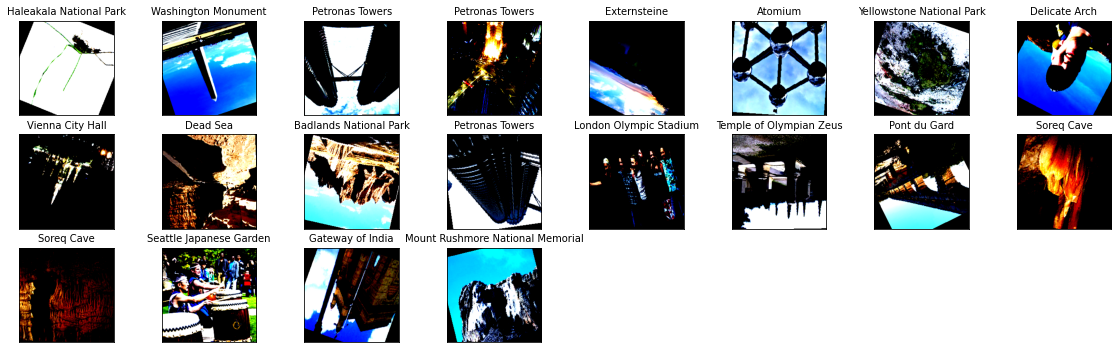

In [4]:
preprocess.visualize(dictionary, train_loader, single=False)

In [36]:
img = next(iter(train_loader))
img

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

In [15]:
from PIL import Image

Image.open(img.numpy().transpose((1, 2, 0))[0, :])

AttributeError: 'list' object has no attribute 'numpy'

In [17]:
img[0, :].numpy()

TypeError: list indices must be integers or slices, not tuple

In [19]:
img[0].shape

torch.Size([64, 3, 224, 224])

In [22]:
plt.show(np.clip(img[0][0, :].numpy().transpose((1, 2, 0)), 0, 1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [24]:
img[0][0, :].size

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


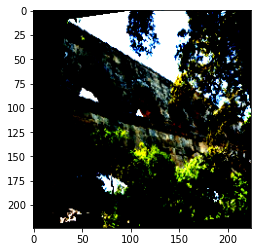

In [27]:
plt.imshow(img[0][0, :].numpy().transpose((1, 2, 0)))

In [28]:
from torchvision import transforms as T
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

denorm = T.Normalize(
        mean=[-m / s for m, s in zip(MEAN, STD)],
        std=[1. / s for s in STD]
)

image = denorm(img[0][0, :])

In [30]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


In [33]:
from torchvision import transforms as T
invTrans = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [45]:
class NormalizeInverse(T.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


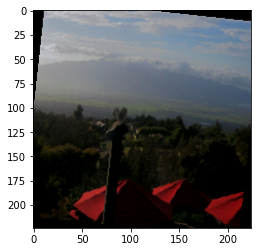

In [55]:
# inv_normalize = T.Normalize(
#     mean=[-0.485 * 0.229, -0.456 * 0.224, -0.406 * 0.255],
#     std=[1/0.229, 1/0.224, 1/0.255]
# )

img = next(iter(train_loader))
# denorm = T.Normalize(
#    mean= [-m/s for m, s in zip(MEAN, STD)],
#    std= [1/s for s in STD]
# )

mean = torch.tensor([0.4915, 0.4823, 0.4468])
std = torch.tensor([0.2470, 0.2435, 0.2616])

# normalize = T.Normalize(mean.tolist(), std.tolist())

unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
img_unn = unnormalize(img[0][0, :])

plt.imshow(np.clip(img_unn.permute(1, 2, 0), 0, 255))
plt.show()

# plt.imshow(input_tensor.numpy().transpose((1, 2, 0)))

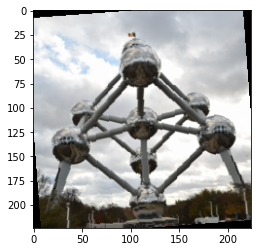

In [68]:
# plt.imshow(np.clip((img[0][0] * std[:, None, None] + mean[:, None, None]).permute(1, 2, 0))
img = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img = img[0][0] * std[:, None, None] + mean[:, None, None]
# Clip the image pixel values
img = np.clip(img, 0, 1)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

In [60]:
img[0][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [ ]:
    denorm = transforms.Normalize(
        mean=[-m / s for m, s in zip(MEAN, STD)],
        std=[1. / s for s in STD]
    )
    # convert = lambda x: np.clip(x.numpy().transpose((1, 2, 0)), 0, 1)
    convert = lambda x: (denorm(x)*255).numpy().transpose((1, 2, 0), 0, 1).astype(np.uint8)
    convert_label = lambda x: str(x.item())

    # transform single images and their labels
    def show_single(image, lbl, index=0):
        # image = image * 2.0 - 1.0         # unnormalize the image
        image = convert(image[index, :])  # transform the image
        lbl = convert_label(lbl[index])   # get the label from dictionary
        return image, dictionary.get_content(int(lbl))